In [4]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import json

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    make_dataset_balanced,
    one_hot_encode_classes,
    split_train_test_set,
)
from rna_learn.load import load_mrna_model, load_dataset

In [5]:
sns.set(palette='colorblind', font_scale=1.3)

In [6]:
run_id = 'run_a1xjj'
learning_type = 'regression'

input_path = os.path.join(os.getcwd(), 'data/ncbi/dataset.csv')
output_folder = os.path.join(os.getcwd(), f'saved_models_mrna/{run_id}/')
model_path = os.path.join(output_folder, f'{learning_type}_model.h5')
metadata_path = os.path.join(output_folder, f'{learning_type}_metadata.json')

In [7]:
learning_rate = 1e-4
model, metadata = load_mrna_model(
    run_id, 
    learning_type, 
    learning_rate, 
    model_path, 
    metadata_path, 
    resume=True,
)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 4)      0           sequence[0][0]                   
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 100)    42000       masking[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 100)          80400       lstm[0][0]                       
______________________________________________________________________________________________

In [7]:
alphabet = metadata['alphabet']
classes = metadata['classes']

dataset_df = load_dataset(input_path, alphabet)

if learning_type == 'regression':
    y, dataset_df = make_dataset_balanced(
        dataset_df,
        cat_name='temperature_range',
        output_col='temperature', 
        classes=classes, 
    )
    y = y.astype(np.float32)
else:
    y_str, dataset_df = make_dataset_balanced(
        dataset_df, 
        cat_name='temperature_range',
        classes=classes,
    )
    y = one_hot_encode_classes(y_str, classes)

sequences = dataset_df['sequence'].values
x = sequence_embedding(sequences, alphabet)

x_train, y_train, x_test, y_test = split_train_test_set(x, y, test_ratio=0.2)

if learning_type == 'regression':
    mean, std = np.mean(y), np.std(y)
    y_test_norm = normalize(y_test, mean, std)
    y_train_norm = normalize(y_train, mean, std)
else:
    y_test_norm = y_test
    y_train_norm = y_train

In [9]:
%%time
model.evaluate(x_test, y_test_norm, verbose=0)

CPU times: user 4min 42s, sys: 1min 12s, total: 5min 54s
Wall time: 2min 3s


1.4063457110121445

In [13]:
def plot_true_vs_prediction_scatter(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p = y_pred[i]
        ax.plot(y_t, y_p, 'o', color=palette[0])
    
    x_straight = range(0, 100)
    ax.plot(x_straight, x_straight, '--', color=palette[1], alpha=0.5)
    
    ax.set_xlabel('Temperature °C (true)')
    ax.set_ylabel('Temperature °C (prediction)')

In [11]:
%%time
y_hat = model(x_test)
y_hat_mean = y_hat.mean().numpy().flatten()
y_mean = denormalize(y_hat_mean, mean, std)
y_std = denormalize(y_hat.stddev().numpy().flatten(), mean, std)

CPU times: user 6min 39s, sys: 8min 35s, total: 15min 15s
Wall time: 5min 26s


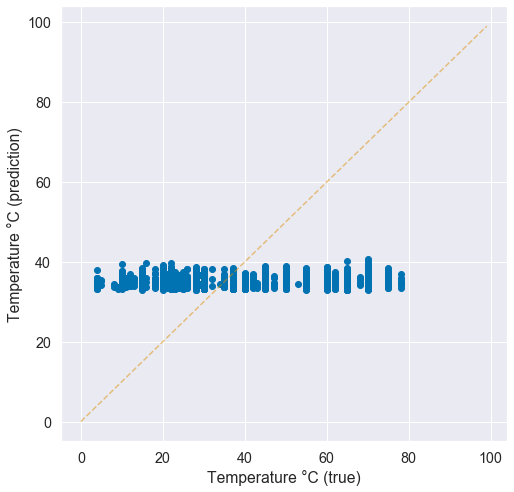

In [16]:
plot_true_vs_prediction_scatter(y_test, y_mean)